# Simulation of production line with defects


In this notebook we will train a Anomalib model using the Anomalib API and our own dataset. This notebook is also part of the Dobot series notebooks.

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>

| Class    | Yellow cube                                                                                                                                           | Red cube                                                                                                                                              | Green cube                                                                                                                                            | Inferencing using Anomalib                                                                                                                            |
| -------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------- |
| Normal   | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> |

Using Anomalib we are expecting to see this result.


# Installing Anomalib

To install anomalib with the required dependencies, please follow the steps under `Install from source` [on GitHub](https://github.com/openvinotoolkit/anomalib?tab=readme-ov-file#-installation).

## Imports


In [1]:
"""501a_training_a_model_with_cubes_from_a_robotic_arm.ipynb."""

from pathlib import Path

from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer

## Download dataset and Robot API/Driver

We should prepare the folder to save the dataset and the Dobot API and drivers. To download the dataset and the Dobot API and drivers we will use anomalib's `download_and_extract` utility function.


In [2]:
from anomalib.data.utils import DownloadInfo, download_and_extract

dataset_download_info = DownloadInfo(
    name="cubes.zip",
    url="https://github.com/openvinotoolkit/anomalib/releases/download/dobot/cubes.zip",
    hashsum="182ce0a48dabf452bf9a6aeb83132466088e30ed7a5c35d7d3a10a9fc11daac4",
)
api_download_info = DownloadInfo(
    name="dobot_api.zip",
    url="https://github.com/openvinotoolkit/anomalib/releases/download/dobot/dobot_api.zip",
    hashsum="eb79bb9c6346be1628a0fe5e1196420dcc4e122ab1aa0d5abbc82f63236f0527",
)
download_and_extract(root=Path.cwd(), info=dataset_download_info)
download_and_extract(root=Path.cwd(), info=api_download_info)

cubes.zip: 6.99MB [00:00, 10.1MB/s]                            
dobot_api.zip: 3.69MB [00:00, 6.86MB/s]                            


### Dataset: Cubes

Prepare your own dataset for normal and defect pieces.


In [3]:
from anomalib.data import Folder

datamodule = Folder(
    name="cubes",
    root=Path.cwd() / "cubes",
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.2,
    train_batch_size=32,
    eval_batch_size=32,
)
datamodule.setup()

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

['image', 'gt_label', 'gt_mask', 'mask_path', 'anomaly_map', 'pred_score', 'pred_mask', 'pred_label', 'explanation', 'image_path']


In [4]:
# Check image size
print(data["image"].shape)

torch.Size([32, 3, 480, 640])


## Model

`anomalib` supports a wide range of unsupervised anomaly detection models. The table in this [link](https://anomalib.readthedocs.io/en/latest/markdown/guides/reference/models/image/index.html) shows the list of models currently supported by `anomalib` library.


### Prepare the Model

We will use Padim model for this use case, which could be imported from `anomalib.models`.


In [5]:
from anomalib.models import Padim

model = Padim(
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

## Training

Now that we set up the datamodule and model, we could now train the model.

The final component to train the model is `Engine` object, which handles train/test/predict/export pipeline. Let's create the engine object to train the model.


In [ ]:
from anomalib.engine import Engine

engine = Engine(accelerator="cpu", devices=1)

engine.fit(model=model, datamodule=datamodule)

In [7]:
# Validation
test_results = engine.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Testing: |          | 0/? [00:00<?, ?it/s]

/home/sakcay/Projects/openvino_build_deploy/ai_ref_kits/defect_detection_anomalib/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric AUROC was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/home/sakcay/Projects/openvino_build_deploy/ai_ref_kits/defect_detection_anomalib/.venv/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric F1Score was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │            1.0            │
│       image_F1Score       │            1.0            │
└───────────────────────────┴───────────────────────────┘

In [ ]:
from anomalib.deploy import ExportType

# Exporting model to OpenVINO
openvino_model_path = engine.export(
    model=model,
    export_type=ExportType.OPENVINO,
    export_root=str(Path.cwd()),
)

For optimization and quantization process, we are using a seamless integration with [NNCF Library](https://github.com/openvinotoolkit/nncf) in the backend of Anomalib. Select one of the following options for optimization or quantization. Replace the openvino_model_path line above in order to export the optimized/quantized model:

```
# Exporting optimized/quantized models

# Post Training Quantization
openvino_model_path = engine.export(
    model, 
    ExportType.OPENVINO, 
    str(Path.cwd()) + "_optimized", 
    compression_type=CompressionType.INT8_PTQ, 
    datamodule=datamodule
    )

# Accuracy-Control Quantization
openvino_model_path=engine.export(
    model, 
    ExportType.OPENVINO, 
    str(Path.cwd()) + "_optimized", 
    compression_type=CompressionType.INT8_ACQ, 
    datamodule=datamodule, 
    metric="F1Score"
    )

# Weight Compression
openvino_model_path=engine.export(
    model, 
    ExportType.OPENVINO, 
    str(Path.cwd()) + "_WEIGHTS", 
    compression_type=CompressionType.FP16, 
    datamodule=datamodule
    )
```

## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.


### Load a Test Image

Let's read an image from the test set and perform inference using OpenVINO inferencer.


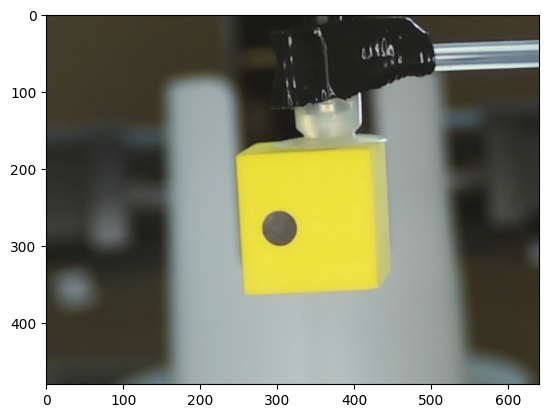

In [9]:
from matplotlib import pyplot as plt

image_path = "./cubes/abnormal/input_20230210134059.jpg"
image = read_image(path="./cubes/abnormal/input_20230210134059.jpg")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.


In [10]:
print(openvino_model_path.exists())

True


In [11]:
inferencer = OpenVINOInferencer(
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference

Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.


In [12]:
print(image.shape)
predictions = inferencer.predict(image=image)

(480, 640, 3)


where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.

### Visualizing Inference Results

`anomalib` provides a number of tools to visualize the inference results. Let's visualize the inference results using the `Visualizer` method.


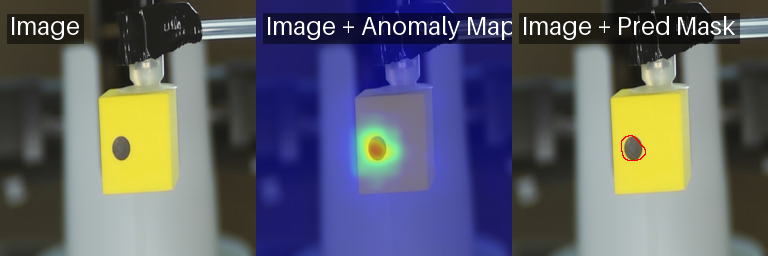

In [13]:
from anomalib.visualization import ImageVisualizer

visualizer = ImageVisualizer()
output_image = visualizer.visualize(predictions)
output_image

It is possible to customize the visualisation. Let's we want to visualise anomaly map and predicted mask separately, and adjust the size of the text.

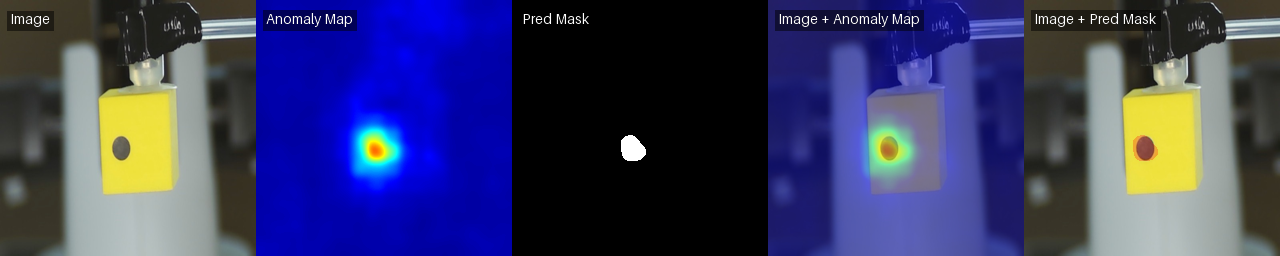

In [14]:
visualizer = ImageVisualizer(
    fields=["image", "anomaly_map", "pred_mask"],
    overlay_fields=[("image", ["anomaly_map"]), ("image", ["pred_mask"])],
    overlay_fields_config={
        "pred_mask": {"alpha": 0.5, "color": (255, 0, 0), "mode": "fill"},
    },
    text_config={"size": 14},
)
output_image = visualizer.visualize(predictions)
output_image


<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=7003a37c-568d-40a5-9718-0d021d8589ca&project=ai_ref_kits/defect_detection_anomalib&file=501a_training_a_model_with_cubes_from_a_robotic_arm.ipynb" />